# OC IML Projet 5 : Catégorisez automatiquement des questions

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique
développez *un système de suggestion de tag* pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.


Ce notebook contient : 
- Exploration des données



## import

In [1640]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 25)

import string
from string import punctuation 

import re

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import scipy.stats as st

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from collections import defaultdict
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

import time

[nltk_data] Downloading package punkt to /Users/gregory/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gregory/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gregory/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Definitions

In [5]:
# source paths
PATH_SOURCE_QUESTIONS = '../../data/QueryResults.csv' 

## Useful functions

In [1621]:
def timing(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
        print('{:s} function took {:.3f} ms'.format(f.__name__, (time2-time1)*1000.0))

        return ret
    return wrap

In [8]:
def display_missing(df):
    '''
    Display dataFrame missing values : barplots & numbers
    ouput : dataFrame containing missing numbers
    '''
    nb_lignes = df.shape[0]
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    df_missing = nb_missing.to_frame()
    df_missing.rename(index=str, columns={0: "nb_missing"}, inplace=True)
    df_missing["ratio"] = 100*df_missing["nb_missing"] / nb_lignes
    fig = plt.figure(figsize=(7, 7))
    liste_name_bars = df_missing.index.values
    liste_name_bars_num = []
    for name in liste_name_bars:
        liste_name_bars_num.append("{} [{}]".format(
            name, df_missing.loc[name, "nb_missing"]))
    ax = sns.barplot(y=liste_name_bars_num, x='ratio', data=df_missing)
    plt.title('Missing lines Ratio over {} lines'.format(nb_lignes))
    ax.set(xlabel='repartition [%]')
    ax.set_xlim([0, 100])
    return df_missing

In [1549]:
def find_topics(quest_iloc, freq_min=0.1, df_topics_pred=df_topics_pred,
               topic_dict=topic_dict):
    '''
    find & display topics about current question (indice loc to be specified)
    '''
    print("Cleaned question n°{}:".format(quest_iloc))
    print(token_dict[df_quest_cleaned.iloc[quest_iloc].name])
    print("\nTags : ", df_quest_cleaned.iloc[quest_iloc].Tags)
    print("")
    fig = plt.figure(figsize=(8, 6))
    df_topics_pred.iloc[quest_iloc].plot()
    #for topic_id_curr in np.nonzero(
    #    df_topics_pred.iloc[quest_iloc] > freq_min)[0]:
    list_topic_label = df_topics_pred.\
        iloc[quest_iloc][df_topics_pred.iloc[quest_iloc] > freq_min].\
        sort_values(ascending=False).index
    #print(list_topic_label)
    list_topic_id =[]
    for label_curr in list_topic_label:
        list_topic_id.append(int(re.findall(r"\d+",label_curr)[0]))
    #print(list_topic_id)
    for topic_id_curr in list_topic_id:
        print("Topic {} : {}".format(topic_id_curr, topic_dict[topic_id_curr]))
    return list(list_topic_id)

In [1566]:
def find_tags_from_topic(iloc_topic, df_topics_tags=df_topics_tags, no_max=10):
    '''
    
    Find best no_max Tags from Topics by giving Topic number as input.
    (By default no_max = 10)
    Uses table linking Tags & Topics 
    
    inputs : 
    - iloc_topic
    - df_topics_tags : table linking Tags to Topics (By default df_topics_tags)
    - no_max : number of best Tags to output
    
    returns the list of no_max Topics numbers (int)
    
    '''
    
    return list(df_topics_tags.sort_values(by="Topic_{}".format(iloc_topic), 
                                           ascending=False).head(no_max).index)

In [1575]:
def find_pred_tags_from_quest(quest_iloc, 
                              freq_min=0.1, 
                              df_topics_pred=df_topics_pred,
                              topic_dict=topic_dict,
                              df_topics_tags=df_topics_tags):
    '''
    Find predicted tags from the question number.
    
    inputs : 
    - quest_iloc : indice question (iloc)
    - df_topics_pred : table of Topics distribution by question 
    - topic_dict contains list of keywords for each topics
    - df_topics_tags : table linking Tags to Topics (By default df_topics_tags)
    
    
    '''

    list_topic_id = find_topics(quest_iloc=quest_iloc, freq_min=freq_min, 
                                df_topics_pred=df_topics_pred_1,
                                topic_dict=topic_dict_1)

    return find_tags_from_topic(iloc_topic=list_topic_id[0],
                                df_topics_tags=df_topics_tags)

In [1617]:
def find_tags_from_text(text, tf_vectorizer, lda_model, 
                        df_topics_tags=df_topics_tags, no_max=10):
    '''
    Predict tags from text using tf, lda and tags2topic table
    
    tf vectorizer , lda and table must be input.
    '''
    # clean the text
    text_cleaned = cleaning_text(text)

    # calculate feature from text with tf already fitted
    feat_curr =  tf_vectorizer.transform([text_cleaned])

    # calculate topic distrib with lda model already fitted
    topic_distrib_pred = lda_model.transform(feat_curr)

    # find best topic from table df_topics_tags
    return find_tags_from_topic(topic_distrib_pred.argmax(), 
                                df_topics_tags=df_topics_tags, 
                                no_max=no_max)

In [1628]:
# prepare dictionnary of translation to suppress ponctuation
replace_punctuation = str.maketrans(string.punctuation,
                                    ' '*len(string.punctuation))
def cleaning_text(questions_curr):

    # lower case
    questions_curr = ' '.join([w.lower() for w in nltk.word_tokenize(questions_curr)])
    # delete newlines
    questions_curr = re.sub(r'\s+', ' ', questions_curr)
    # delete single quotes
    questions_curr = re.sub(r"\'", " ", questions_curr)
    # delete tags
    questions_curr = re.sub('<[^<]+?>',' ', questions_curr)
    # delete numbers (forming group = word with only numbers 
    # example : delete "123" but not "a123")
    questions_curr = re.sub(r'\b\d+\b','', questions_curr) 
    # delete ponctuation (replace by space)
    questions_curr = questions_curr.translate(replace_punctuation)

    return questions_curr

In [ ]:
stemmer = EnglishStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [ ]:
def find_tags_from_text(text, tf_vectorizer, lda_model, 
                        df_topics_tags=df_topics_tags, no_max=10):
    '''
    Predict tags from text using tf, lda and tags2topic table
    
    tf vectorizer , lda and table must be input.
    '''
    # clean the text
    text_cleaned = cleaning_text(text)

    # calculate feature from text with tf already fitted
    feat_curr =  tf_vectorizer.transform([text_cleaned])

    # calculate topic distrib with lda model already fitted
    topic_distrib_pred = lda_model.transform(feat_curr)

    # find best topic from table df_topics_tags
    return find_tags_from_topic(topic_distrib_pred.argmax(), 
                                df_topics_tags=df_topics_tags, 
                                no_max=no_max)

## Loading

In [6]:
# loading each sources
df_quest = pd.read_csv(PATH_SOURCE_QUESTIONS, sep=',')

### Questions/Answers

In [7]:
df_quest.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate
0,50000002,2,NaN,49999948.0,2018-04-24 11:00:00,NaN,2,NaN,<p>You need to have a pointer to the <code>ma...,1983495.0,NaN,1983495.0,NaN,2018-04-24 12:14:36,2018-04-24 12:14:36,NaN,NaN,NaN,4,NaN,NaN,NaN
1,50000003,2,NaN,49995279.0,2018-04-24 11:00:00,NaN,1,NaN,<p>The old state is discarded. If you want to ...,506441.0,NaN,NaN,NaN,NaN,2018-04-24 11:00:00,NaN,NaN,NaN,3,NaN,NaN,NaN
2,50000004,2,NaN,49999911.0,2018-04-24 11:00:01,NaN,0,NaN,<p>If you are trying to achieve the above outp...,6155965.0,NaN,NaN,NaN,NaN,2018-04-24 11:00:01,NaN,NaN,NaN,6,NaN,NaN,NaN
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,NaN,2018-04-24 11:03:32,2018-04-24 13:15:50,How to insert an entry to a table only if it d...,<c#><sql><sql-server>,3.0,0,NaN,NaN,NaN
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,NaN,NaN,2018-05-01 13:24:04,System DMV's missing from SQL Server 2017 mast...,<sql-server><sql-server-data-tools>,1.0,2,NaN,NaN,NaN


In [36]:
df_quest["Id"].nunique()

50000

,nb_missing,ratio
Id,0,0.000
PostTypeId,0,0.000
LastActivityDate,0,0.000
CommentCount,0,0.000
CreationDate,0,0.000
Score,0,0.000
Body,24,0.048
OwnerUserId,508,1.016
ParentId,21280,42.560
ViewCount,28792,57.584


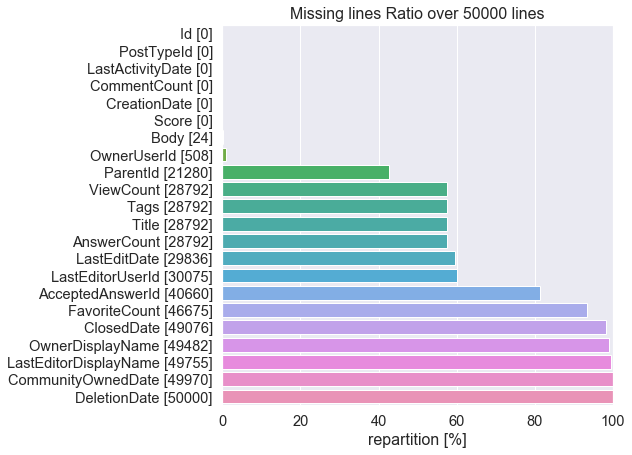

In [9]:
display_missing(df_quest)

### Filter questions

Questions only don't have ParentId.

We filter questions with no ParentId and with non-Nan Body

In [596]:
df_quest_cleaned = df_quest[df_quest["ParentId"].isna()]
df_quest_cleaned = df_quest_cleaned[df_quest_cleaned["Body"].notna()]

,nb_missing,ratio
Id,0,0.000000
LastActivityDate,0,0.000000
Score,0,0.000000
CommentCount,0,0.000000
Body,0,0.000000
PostTypeId,0,0.000000
CreationDate,0,0.000000
ViewCount,48,0.225819
Title,48,0.225819
AnswerCount,48,0.225819


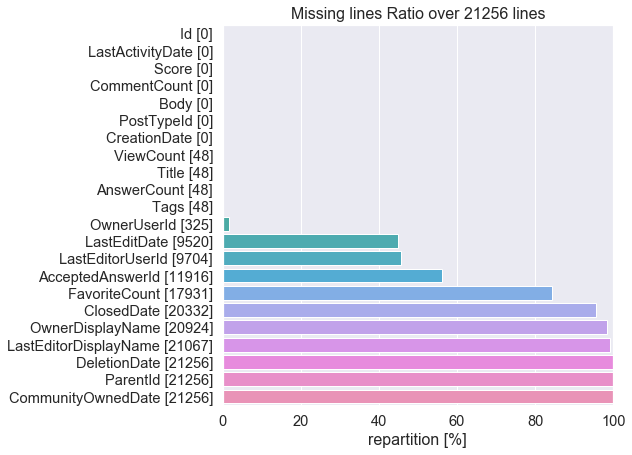

In [597]:
display_missing(df_quest_cleaned)

In [598]:
df_quest_cleaned[df_quest_cleaned.Title.isna()]

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate
655,50000860,4,NaN,NaN,2018-04-24 11:44:34,NaN,0,NaN,osgEarth is a geospatial SDK and terrain engin...,1332041.0,NaN,1332041.0,NaN,2018-04-25 07:25:46,2018-04-25 07:25:46,NaN,NaN,NaN,0,NaN,NaN,NaN
2576,50003399,5,NaN,NaN,2018-04-24 13:49:51,NaN,0,NaN,<p>This is an ambiguous tag that should not be...,1356107.0,NaN,1356107.0,NaN,2018-04-26 12:02:53,2018-04-26 12:02:53,NaN,NaN,NaN,0,NaN,NaN,NaN
2577,50003400,4,NaN,NaN,2018-04-24 13:49:51,NaN,0,NaN,DO NOT USE THIS TAG! Please find a more releva...,1481116.0,NaN,1356107.0,NaN,2018-04-26 12:06:27,2018-04-26 12:06:27,NaN,NaN,NaN,0,NaN,NaN,NaN
8467,50011191,4,NaN,NaN,2018-04-24 21:49:32,NaN,0,NaN,Use this tag for questions specific to Lightwe...,5862071.0,NaN,5862071.0,NaN,2018-04-24 21:49:32,2018-04-24 21:49:32,NaN,NaN,NaN,0,NaN,NaN,NaN
9636,50012751,5,NaN,NaN,2018-04-25 01:22:51,NaN,0,NaN,"<p><a href=""https://cloud.google.com/profiler/...",848626.0,NaN,848626.0,NaN,2018-04-25 10:21:23,2018-04-25 10:21:23,NaN,NaN,NaN,0,NaN,NaN,NaN
9637,50012752,4,NaN,NaN,2018-04-25 01:22:51,NaN,0,NaN,Google Cloud Profiler (aka Stackdriver Profile...,848626.0,NaN,848626.0,NaN,2018-04-26 04:06:31,2018-04-26 04:06:31,NaN,NaN,NaN,0,NaN,NaN,NaN
12039,50015982,5,NaN,NaN,2018-04-25 07:02:19,NaN,0,NaN,<p>Full details on downloading and using F#-Ch...,4288666.0,NaN,4288666.0,NaN,2018-04-25 12:16:54,2018-04-25 12:16:54,NaN,NaN,NaN,0,NaN,NaN,NaN
12040,50015983,4,NaN,NaN,2018-04-25 07:02:19,NaN,0,NaN,The F# Charting library implements charting su...,4288666.0,NaN,4288666.0,NaN,2018-04-25 22:24:30,2018-04-25 22:24:30,NaN,NaN,NaN,0,NaN,NaN,NaN
17297,50022969,5,NaN,NaN,2018-04-25 12:55:35,NaN,0,NaN,<p>Amazon Transcribe is an automatic speech re...,123378.0,NaN,123378.0,NaN,2018-04-25 18:45:32,2018-04-25 18:45:32,NaN,NaN,NaN,0,NaN,NaN,NaN
17298,50022970,4,NaN,NaN,2018-04-25 12:55:35,NaN,0,NaN,Amazon Transcribe is a speech recognition serv...,123378.0,NaN,123378.0,NaN,2018-04-26 05:32:48,2018-04-26 05:32:48,NaN,NaN,NaN,0,NaN,NaN,NaN


In [599]:
df_quest_cleaned[df_quest_cleaned.Id == 50060292].Body.tolist()

['<p>This library is deprecated and is no longer being used. Use <a href="/questions/tagged/boost-log" class="post-tag" title="show questions tagged &#39;boost-log&#39;" rel="tag">boost-log</a> instead. </p>\n\n<p><a href="https://meta.stackoverflow.com/questions/298315/burninate-boost-logging">Burninate boost-logging</a> </p>\n']

In [600]:
df_quest_cleaned = df_quest_cleaned[df_quest_cleaned.Title.notna()]

,nb_missing,ratio
Id,0,0.000000
LastActivityDate,0,0.000000
AnswerCount,0,0.000000
Title,0,0.000000
ViewCount,0,0.000000
Score,0,0.000000
Body,0,0.000000
CreationDate,0,0.000000
PostTypeId,0,0.000000
CommentCount,0,0.000000


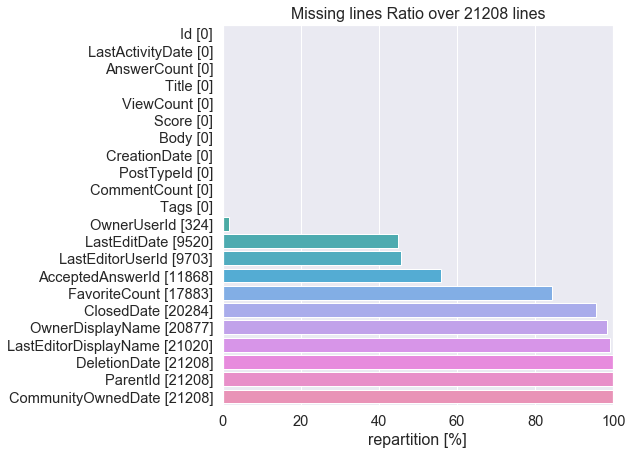

In [601]:
display_missing(df_quest_cleaned)

In [602]:
df_quest_cleaned[df_quest_cleaned["OwnerUserId"].isna()].head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate
117,50000152,1,50000270.0,NaN,2018-04-24 11:07:30,NaN,1,33.0,<p>I'm working on a blog. On its first page I ...,NaN,user9690627,3848833.0,NaN,2018-04-24 12:19:36,2018-04-24 12:19:36,Django - Combining Multiple Variables,<python><django>,1.0,0,NaN,NaN,NaN
140,50000185,1,50000460.0,NaN,2018-04-24 11:09:32,NaN,1,95.0,<p>I'm trying to write a PHP code that's a bit...,NaN,user9474945,4248328.0,NaN,2018-04-24 11:10:22,2018-04-24 15:47:15,Php date move to next month,<php>,4.0,2,NaN,NaN,NaN
179,50000239,1,50003124.0,NaN,2018-04-24 11:12:02,NaN,0,42.0,<p>I'm trying to append into the html code a j...,NaN,user9557101,NaN,user9557101,2018-04-24 11:29:35,2018-04-24 13:37:33,how to append a javascript function with 2 var...,<javascript><laravel>,1.0,3,NaN,NaN,NaN
711,50000932,1,NaN,NaN,2018-04-24 11:48:21,NaN,0,882.0,<p>I have some problems with 'entityManagerFac...,NaN,user7866438,3535298.0,NaN,2018-04-24 12:49:52,2018-04-24 12:49:52,Parameter 0 of constructor in com.springboot.D...,<java><hibernate><spring-boot><spring-data-jpa...,0.0,5,NaN,NaN,NaN
1291,50001710,1,NaN,NaN,2018-04-24 12:28:33,NaN,0,340.0,<p>i have a bottom navigation in main activity...,NaN,user9585742,7666442.0,NaN,2018-04-24 12:36:36,2018-04-24 12:36:36,putting recycler view above bottom navigation,<java><android><android-layout>,2.0,4,NaN,NaN,NaN


## Preparation data

### Title & Body concatenation

In [610]:
df_quest_cleaned["Text"] = df_quest_cleaned["Title"] + " " + df_quest_cleaned["Body"]
df_quest_cleaned.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,Text
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,NaN,2018-04-24 11:03:32,2018-04-24 13:15:50,How to insert an entry to a table only if it d...,<c#><sql><sql-server>,3.0,0,NaN,NaN,NaN,How to insert an entry to a table only if it d...
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,NaN,NaN,2018-05-01 13:24:04,System DMV's missing from SQL Server 2017 mast...,<sql-server><sql-server-data-tools>,1.0,2,NaN,NaN,NaN,System DMV's missing from SQL Server 2017 mast...
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,NaN,2018-04-24 11:28:04,2018-04-24 12:02:43,how to insert data in databse without page rel...,<javascript><php><ajax>,1.0,4,NaN,NaN,NaN,how to insert data in databse without page rel...
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,NaN,NaN,2018-04-24 11:46:52,How to upload image using multipart in Amazon S3,<android><amazon-s3><file-upload><multipart>,1.0,0,NaN,NaN,NaN,How to upload image using multipart in Amazon ...
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,NaN,NaN,2018-04-24 11:05:05,DB2 SQL CROSSTAB,<sql><db2><crosstab>,1.0,0,NaN,NaN,NaN,DB2 SQL CROSSTAB <p>I would like to output a t...


In [611]:
df_quest_cleaned.head(1)

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,Text
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,NaN,2018-04-24 11:03:32,2018-04-24 13:15:50,How to insert an entry to a table only if it d...,<c#><sql><sql-server>,3.0,0,NaN,NaN,NaN,How to insert an entry to a table only if it d...


In [612]:
df_quest_cleaned.head(1).Title.tolist()

['How to insert an entry to a table only if it does not exist']

In [613]:
df_quest_cleaned.head(1).Body.tolist()

["<p>My table looks like this  on sql server</p>\n\n<pre><code>wordId     word      \n----------------\n1214       pen           \n1215       men    \n1216       cat  \n</code></pre>\n\n<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>\n"]

In [614]:
df_quest_cleaned.head(1).Text.tolist()

["How to insert an entry to a table only if it does not exist <p>My table looks like this  on sql server</p>\n\n<pre><code>wordId     word      \n----------------\n1214       pen           \n1215       men    \n1216       cat  \n</code></pre>\n\n<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>\n"]

In [13]:
test = "Bonjour, je suis un texte d'exemple pour le cours d'Openclassrooms. Soyez attentifs à ce cours !"

nltk.word_tokenize(test)

['Bonjour',
 ',',
 'je',
 'suis',
 'un',
 'texte',
 "d'exemple",
 'pour',
 'le',
 'cours',
 "d'Openclassrooms",
 '.',
 'Soyez',
 'attentifs',
 'à',
 'ce',
 'cours',
 '!']

In [28]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
tokens_test = tokenizer.tokenize("Bonjour, je suis un texte d'exemple pour le cours d'Openclassrooms. Soyez attentifs à ce cours !")
tokens_test

['Bonjour',
 'je',
 'suis',
 'un',
 'texte',
 'd',
 'exemple',
 'pour',
 'le',
 'cours',
 'd',
 'Openclassrooms',
 'Soyez',
 'attentifs',
 'à',
 'ce',
 'cours']

In [622]:

#questions = defaultdict(set)

questions = df_quest_cleaned.filter(items=["Text"]).to_dict()
questions = questions["Text"]
print('{} questions'.format(len(questions)))

21208 questions


In [623]:
questions[4]

'System DMV\'s missing from SQL Server 2017 master.dacpac in SSDT 2015 <p>I have Ola Hallengren\'s excellent Maintenance Solution scripts incorporated in to a DBA tools database project.  This is maintained using SSDT 2015 with a target platform of SQL Server 2012.  The project includes references to the built-in system databases master &amp; msdb.  The project builds successfully.</p>\n\n<p>Ola has recently <a href="https://ola.hallengren.com/versions.html" rel="nofollow noreferrer">updated</a> his scripts and they now include references to new SQL Server 2017 DMV\'s, so incorporating the updated scripts into my database project generated unresolved reference errors for the new DMV\'s.  </p>\n\n<pre><code>SQL71502: Procedure: [dbo].[DatabaseBackup] has an unresolved reference to object [sys].[dm_os_host_info]\nSQL71502: Procedure: [dbo].[DatabaseBackup] has an unresolved reference to object [sys].[dm_db_log_stats]\n</code></pre>\n\n<p>Although I don\'t have SQL Server 2017 installed a

### Words in questions

In [624]:
tokenizer = nltk.RegexpTokenizer(r'\w+')

def freq_stats_corpora():
    '''
    Statistics about words in questions
    '''
    corpora = defaultdict(list)

    # Création d'un corpus de tokens par question
    for id_curr,questions_curr in questions.items():        
        try:
            corpora[id_curr] += tokenizer.tokenize(questions_curr.lower())
        except:
            print('Question {} : Error body empty'.format(id_curr))
            
    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
        
    return (freq, stats, corpora)

# Récupération des comptages
freq, stats, corpora = freq_stats_corpora()
df_stats = pd.DataFrame.from_dict(stats, orient='index')

# Affichage des fréquences
#df.sort(columns='total', ascending=False)
#df = df.sort_values(by=['total'], ascending=False)
#df.head(50).plot(kind='bar', color="#f56900", title='Top 50 Rappeurs par nombre de mots')

In [625]:
df_stats.head()

,total,unique
3,82,49
4,424,192
9,355,89
10,31,24
12,70,39


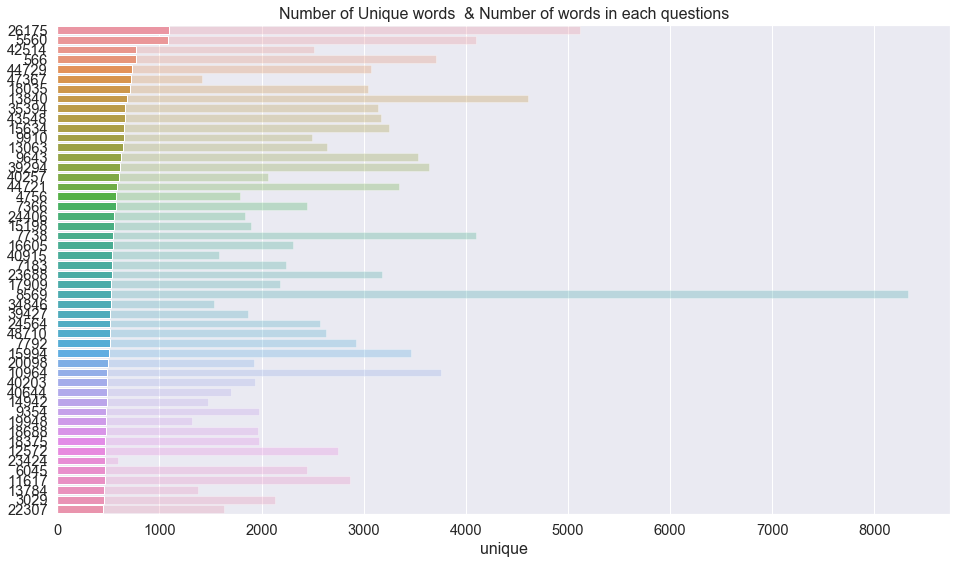

In [626]:
fig = plt.figure(figsize=(16, 9))
plt.title("Number of Unique words  & Number of words in each questions")
df_plot = df_stats.sort_values(by=['unique'], ascending=False).head(50)
ax = sns.barplot(y=df_plot.index, order= df_plot.index,
            x="total",orient="h",
            data=df_plot, alpha=0.3)
sns.barplot(y=df_plot.index, order= df_plot.index,
            x="unique",orient="h",
            data=df_plot, ax=ax)

In [627]:
df_plot.T

,26175,5560,42514,566,44729,47367,18035,13840,35394,43548,15634,9910,...,14942,9354,19948,18688,18375,12572,23424,6045,11617,13784,3029,22307
total,5119,4100,2515,3708,3076,1420,3042,4610,3139,3172,3243,2492,...,1479,1974,1317,1964,1974,2753,595,2447,2869,1381,2130,1633
unique,1096,1087,770,767,733,719,712,683,667,664,649,648,...,483,479,475,473,470,468,467,467,465,455,453,451


In [628]:
len(df_quest_cleaned.loc[14942].Body)

9799

In [629]:
df_quest_cleaned.loc[14942].Body

"<p>My outer <code>RecyclerView</code> crashes either with</p>\n\n<pre><code>IllegalArgumentException: Scrapped or attached views may not be recycled. isScrap:false isAttached:true...\n</code></pre>\n\n<p>or</p>\n\n<pre><code>IllegalStateException: The specified child already has a parent. You must call removeView() on the child's parent first.\n</code></pre>\n\n<p>Like the title suggests I have an <code>RecyclerView</code> in the list item layout of the first <code>RecyclerView</code>. This layout is used to display messages and the \ninner <code>RecyclerView</code> to display attachments that come with the message. The inner <code>RecyclerViews</code> visibility is set to either <code>GONE</code> or <code>VISIBLE</code> depending whether the message has any attachments or not. The simplified outer list item layout looks like this</p>\n\n<pre><code>ConstraintLayout\n    TextView\n    TextView\n    TextView\n    RecyclerView\n</code></pre>\n\n<p>And the part of the adapter that handles

In [630]:
tokenizer.tokenize(df_quest_cleaned.loc[14942].Body)

['p',
 'My',
 'outer',
 'code',
 'RecyclerView',
 'code',
 'crashes',
 'either',
 'with',
 'p',
 'pre',
 'code',
 'IllegalArgumentException',
 'Scrapped',
 'or',
 'attached',
 'views',
 'may',
 'not',
 'be',
 'recycled',
 'isScrap',
 'false',
 'isAttached',
 'true',
 'code',
 'pre',
 'p',
 'or',
 'p',
 'pre',
 'code',
 'IllegalStateException',
 'The',
 'specified',
 'child',
 'already',
 'has',
 'a',
 'parent',
 'You',
 'must',
 'call',
 'removeView',
 'on',
 'the',
 'child',
 's',
 'parent',
 'first',
 'code',
 'pre',
 'p',
 'Like',
 'the',
 'title',
 'suggests',
 'I',
 'have',
 'an',
 'code',
 'RecyclerView',
 'code',
 'in',
 'the',
 'list',
 'item',
 'layout',
 'of',
 'the',
 'first',
 'code',
 'RecyclerView',
 'code',
 'This',
 'layout',
 'is',
 'used',
 'to',
 'display',
 'messages',
 'and',
 'the',
 'inner',
 'code',
 'RecyclerView',
 'code',
 'to',
 'display',
 'attachments',
 'that',
 'come',
 'with',
 'the',
 'message',
 'The',
 'inner',
 'code',
 'RecyclerViews',
 'code',
 'v

In [631]:
'tEst test'.encode('utf-8').decode('utf-8')

'tEst test'

### Significant words in questions

In [632]:
# Premièrement, on récupère la fréquence totale de chaque mot sur tout le corpus
# de questions
freq_totale = nltk.Counter()
for k, v in questions.items():
    freq_totale += freq[k]



In [633]:
freq_totale.most_common(50)

[('p', 202005),
 ('code', 131321),
 ('the', 121239),
 ('gt', 118769),
 ('i', 115208),
 ('lt', 106133),
 ('to', 86611),
 ('a', 82889),
 ('pre', 67216),
 ('in', 50576),
 ('is', 48381),
 ('0', 45769),
 ('and', 43771),
 ('this', 39396),
 ('1', 39346),
 ('of', 33180),
 ('it', 29148),
 ('for', 27661),
 ('if', 23332),
 ('class', 23294),
 ('that', 21850),
 ('with', 21757),
 ('2', 21554),
 ('my', 20638),
 ('data', 19884),
 ('com', 19661),
 ('have', 19599),
 ('from', 19443),
 ('on', 18727),
 ('but', 18357),
 ('not', 18253),
 ('as', 16884),
 ('at', 16517),
 ('div', 16493),
 ('strong', 15914),
 ('id', 15655),
 ('new', 15235),
 ('name', 15108),
 ('https', 14915),
 ('3', 14266),
 ('can', 14217),
 ('how', 14163),
 ('string', 14120),
 ('java', 14100),
 ('t', 13946),
 ('get', 13191),
 ('error', 13092),
 ('using', 12703),
 ('li', 12519),
 ('file', 12417)]

In [634]:
# Deuxièmement on décide manière un peu arbitraire du nombre de mots les plus 
# fréquents à supprimer. On pourrait afficher un graphe d'évolution du nombre 
# de mots pour se rendre compte et avoir une meilleure heuristique. 
# On créé notre set de stopwords final qui cumule ainsi les 100 mots les plus 
# fréquents du corpus ainsi que l'ensemble de stopwords par défaut présent 
# dans la librairie NLTK
most_freq = freq_totale.most_common(100)
sw = set()
for tuple_freq in most_freq:
    sw.add(tuple_freq[0])
    
sw.update(tuple(nltk.corpus.stopwords.words('english')))
sw

{'0',
 '1',
 '10',
 '2',
 '3',
 '4',
 '5',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'amp',
 'an',
 'and',
 'android',
 'any',
 'app',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'c',
 'can',
 'class',
 'code',
 'com',
 'couldn',
 "couldn't",
 'd',
 'data',
 'did',
 'didn',
 "didn't",
 'div',
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'error',
 'false',
 'few',
 'file',
 'for',
 'from',
 'function',
 'further',
 'get',
 'gt',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'href',
 'html',
 'https',
 'i',
 'id',
 'if',
 'image',
 'import',
 'in',
 'int',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'java',
 'js',
 'just',
 'li',
 'like',
 'll',
 'l

In [635]:
nltk.corpus.stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [636]:
def freq_stats_corpora2():
    '''
    Statistics about significant words in questions
    '''
    corpora = defaultdict(list)

    # Création d'un corpus de tokens par artiste
    for id_curr,questions_curr in questions.items():
        #print(id_curr)
        try:
            tokens = tokenizer.tokenize(questions_curr.lower())
            corpora[id_curr] += [w for w in tokens if not w in list(sw)]
        except:
            print('Question {} : Error body empty'.format(id_curr))
            

    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
        
    return (freq, stats, corpora)

freq2, stats2, corpora2 = freq_stats_corpora2()

In [637]:
df_stats2 = pd.DataFrame.from_dict(stats2, orient='index')
df_stats2.head()

,total,unique
3,35,24
4,211,119
9,141,50
10,12,9
12,34,23


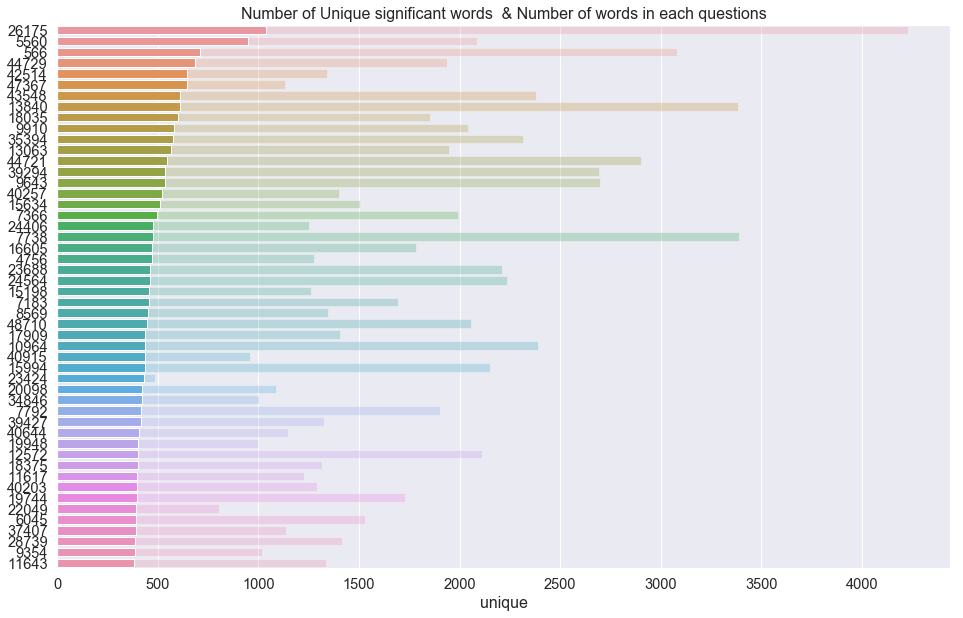

In [638]:
fig = plt.figure(figsize=(16, 10))
plt.title("Number of Unique significant words  & Number of words in each questions")
df_plot = df_stats2.sort_values(by=['unique'], ascending=False).head(50)
ax = sns.barplot(y=df_plot.index, order= df_plot.index,
            x="total",orient="h",
            data=df_plot, alpha=0.3)
sns.barplot(y=df_plot.index, order= df_plot.index,
            x="unique",orient="h",
            data=df_plot, ax=ax)

In [639]:
df_plot.head()

,total,unique
26175,4227,1035
5560,2087,949
566,3080,708
44729,1937,682
42514,1340,646


In [640]:
df_stats2.loc[26175]

total     4227
unique    1035
Name: 26175, dtype: int64

In [641]:
df_stats.loc[26175]

total     5119
unique    1096
Name: 26175, dtype: int64

### Stems of words in questions

In [642]:
def freq_stats_corpora3():
    '''
    Statistics about stems of words in questions
    '''
    corpora = defaultdict(list)
    stemmer = EnglishStemmer()
    # Création d'un corpus de tokens par artiste
    for id_curr,questions_curr in questions.items():
        try:
            tokens = tokenizer.tokenize(questions_curr.lower())
            corpora[id_curr] += \
                [stemmer.stem(w) for w in tokens if not w in list(sw)]
        except:
            print('Question {} : Error body empty'.format(id_curr))
            
    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
        
    return (freq, stats, corpora)

freq3, stats3, corpora3 = freq_stats_corpora3()

df_stats3 = pd.DataFrame.from_dict(stats3, orient='index')
df_stats3.head()

,total,unique
3,35,23
4,211,108
9,141,50
10,12,9
12,34,23


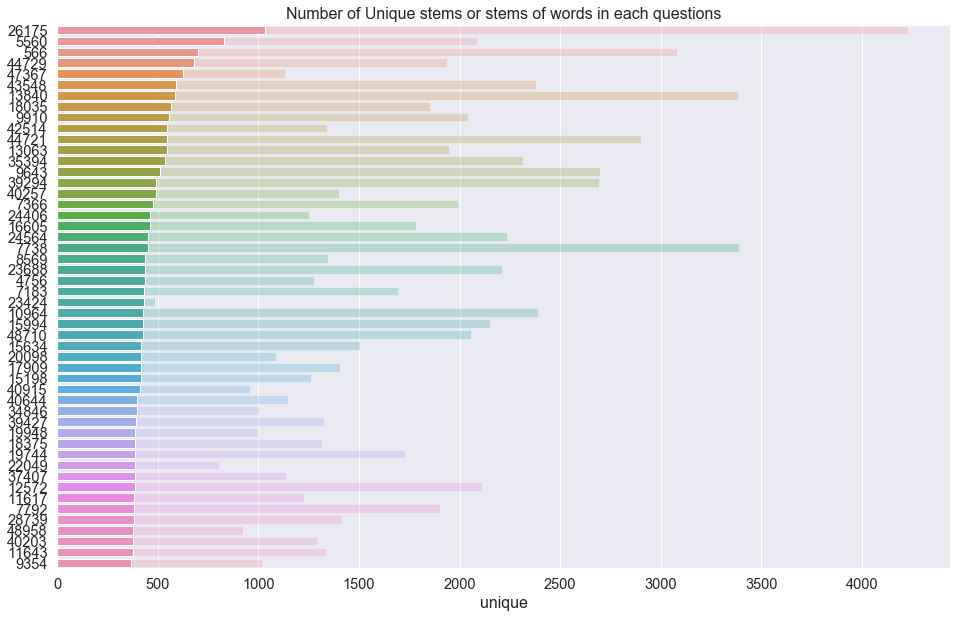

In [643]:
fig = plt.figure(figsize=(16, 10))
plt.title("Number of Unique stems or stems of words in each questions")
df_plot = df_stats3.sort_values(by=['unique'], ascending=False).head(50)
ax = sns.barplot(y=df_plot.index, order= df_plot.index,
            x="total",orient="h",
            data=df_plot, alpha=0.3)
sns.barplot(y=df_plot.index, order= df_plot.index,
            x="unique",orient="h",
            data=df_plot, ax=ax)

In [644]:
df_plot.head()

,total,unique
26175,4227,1030
5560,2087,829
566,3080,701
44729,1937,681
47367,1132,626


### Cleaning Text

In [1580]:
token_dict = dict()
# for each questions, prepare token : lower, no ponctuation
for id_curr, questions_curr in questions.items():
    try:
        # save cleaned text into dict output
        token_dict[id_curr] = cleaning_text(questions_curr) 
    except:
        print('Question {} : Error body empty'.format(id_curr))

### TF-IDF

In [645]:
corpus = [
...     'This is the first document.',
...     'This document is the second document.',
...     'And this is the third one.',
...     'Is this the first document?',
... ]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(X.shape)
(4, 9)

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
(4, 9)


(4, 9)

In [646]:
X

<4x9 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [647]:
print(X)

  (0, 8)	0.38408524091481483
  (0, 3)	0.38408524091481483
  (0, 6)	0.38408524091481483
  (0, 2)	0.5802858236844359
  (0, 1)	0.46979138557992045
  (1, 8)	0.281088674033753
  (1, 3)	0.281088674033753
  (1, 6)	0.281088674033753
  (1, 1)	0.6876235979836938
  (1, 5)	0.5386476208856763
  (2, 8)	0.267103787642168
  (2, 3)	0.267103787642168
  (2, 6)	0.267103787642168
  (2, 0)	0.511848512707169
  (2, 7)	0.511848512707169
  (2, 4)	0.511848512707169
  (3, 8)	0.38408524091481483
  (3, 3)	0.38408524091481483
  (3, 6)	0.38408524091481483
  (3, 2)	0.5802858236844359
  (3, 1)	0.46979138557992045


In [649]:
'''
stemmer = EnglishStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems


token_dict = dict()


# for each questions, prepare token : lower, no ponctuation
for id_curr,questions_curr in questions.items():
    text = questions_curr
    try:
        # lower text
        lowers = text.lower()
        
        # prepare dictionnary of translation to suppress ponctuation
        replace_punctuation = str.maketrans(string.punctuation, 
                                            ' '*len(string.punctuation))
        #no_punctuation = lowers.translate(str.maketrans('','',
        #                                                string.punctuation))
        
        # into text, replace ponctuations by spaces
        no_punctuation = lowers.translate(replace_punctuation)
        
        # save text into dict output
        token_dict[id_curr] = no_punctuation
    except:
        print('Question {} : Error body empty'.format(id_curr))
'''

In [650]:
# prepare tf-idf calculation
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=sw, analyzer='word')
# calculate tf-idf
values = tfidf.fit_transform(token_dict.values())

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'fals', 'imag', 'might', 'must', "n't", 'need', 'noreferr', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'valu', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [651]:
df_quest_cleaned.iloc[0].Body

"<p>My table looks like this  on sql server</p>\n\n<pre><code>wordId     word      \n----------------\n1214       pen           \n1215       men    \n1216       cat  \n</code></pre>\n\n<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>\n"

In [652]:
names = tfidf.get_feature_names()

In [653]:
names[40401:40421]

['channelno2',
 'channelnumb',
 'channeloper',
 'channeloperationshandl',
 'channelopt',
 'channelplay',
 'channelprocessingfilt',
 'channelread',
 'channelread0',
 'channelresult',
 'channelsecurityinterceptor',
 'channelsendoper',
 'channelsetdsp',
 'channelsftp',
 'channelsliveservertestcas',
 'channelt',
 'channeltyp',
 'channelwriteexcept',
 'chao',
 'chapel']

In [654]:
names[136617]

'usessl'

In [655]:
print(values[4])

  (0, 127674)	0.08457921817824525
  (0, 123672)	0.20362802190384818
  (0, 124711)	0.11662263649002341
  (0, 113695)	0.2640932926539759
  (0, 5190)	0.20056393547060744
  (0, 137218)	0.062251833434315965
  (0, 49648)	0.4148483976927942
  (0, 47010)	0.5347542404724381
  (0, 141370)	0.06887229312876689
  (0, 99794)	0.08516725633627192
  (0, 132336)	0.1298171669475516
  (0, 116806)	0.08183359725718878
  (0, 45696)	0.08509598652096975
  (0, 43151)	0.08836516965970231
  (0, 43152)	0.20059296200265253
  (0, 43153)	0.20267705182655568
  (0, 43154)	0.2116557404446573
  (0, 10781)	0.22159335611857817
  (0, 4776)	0.20583840977736903
  (0, 12432)	0.22360520485241284
  (0, 6359)	0.21838396245225578


In [657]:
values[4][(0, 47010)]

0.5347542404724381

In [658]:
type(values[4])

scipy.sparse.csr.csr_matrix

In [659]:
values[4].getrow(0).toarray().shape

(1, 145511)

In [660]:
values[4].indices

array([127674, 123672, 124711, 113695,   5190, 137218,  49648,  47010,
       141370,  99794, 132336, 116806,  45696,  43151,  43152,  43153,
        43154,  10781,   4776,  12432,   6359], dtype=int32)

In [661]:
values[4].indices.shape

(21,)

In [662]:
values[0]

<1x145511 sparse matrix of type '<class 'numpy.float64'>'
	with 25 stored elements in Compressed Sparse Row format>

In [663]:
n_quest = 0

dict_names_quest_curr = dict()
for indice_curr, value_curr in zip(values[n_quest].indices, 
                                   values[n_quest].data):
    dict_names_quest_curr[names[indice_curr]] = value_curr
pd.DataFrame(data=dict_names_quest_curr, index=[n_quest]).T

,0
insert,0.158114
entri,0.087600
tabl,0.182340
onli,0.103170
doe,0.055231
exist,0.218723
look,0.056710
sql,0.073165
server,0.060880
wordid,0.768564


In [664]:
df_quest_cleaned.iloc[0].Body

"<p>My table looks like this  on sql server</p>\n\n<pre><code>wordId     word      \n----------------\n1214       pen           \n1215       men    \n1216       cat  \n</code></pre>\n\n<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>\n"

In [665]:
questions[3]

"How to insert an entry to a table only if it does not exist <p>My table looks like this  on sql server</p>\n\n<pre><code>wordId     word      \n----------------\n1214       pen           \n1215       men    \n1216       cat  \n</code></pre>\n\n<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>\n"

In [666]:
test = "Bonjour, je suis un texte d'exemple pour le cours d'Openclassrooms. Soyez attentifs à ce cours !"
tokens = tokenizer.tokenize(test.lower())
list(nltk.bigrams(tokens))

[('bonjour', 'je'),
 ('je', 'suis'),
 ('suis', 'un'),
 ('un', 'texte'),
 ('texte', 'd'),
 ('d', 'exemple'),
 ('exemple', 'pour'),
 ('pour', 'le'),
 ('le', 'cours'),
 ('cours', 'd'),
 ('d', 'openclassrooms'),
 ('openclassrooms', 'soyez'),
 ('soyez', 'attentifs'),
 ('attentifs', 'à'),
 ('à', 'ce'),
 ('ce', 'cours')]

## Models unsupervised

### LDA

#### Example test

In [667]:
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
     'Is this the first document?']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
pd.DataFrame(data=X.toarray(), columns=[vectorizer.get_feature_names()]).T

,0,1,2,3
and,0,0,1,0
document,1,2,0,1
first,1,0,0,1
is,1,1,1,1
one,0,0,1,0
second,0,1,0,0
the,1,1,1,1
third,0,0,1,0
this,1,1,1,1


In [968]:
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?']
vectorizer = CountVectorizer(max_df=3/5, min_df=1)
X = vectorizer.fit_transform(corpus)
pd.DataFrame(data=X.toarray(), columns=[vectorizer.get_feature_names()]).T

,0,1,2,3
and,0,0,1,0
first,1,0,0,1
one,0,0,1,0
second,0,1,0,0
third,0,0,1,0


In [962]:
5/22

0.22727272727272727

#### 1st test LDA

In [669]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, 
                                stop_words=sw)
tf = tf_vectorizer.fit_transform(token_dict.values())

no_topics = 200

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0).fit(tf)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_vectorizer.get_feature_names(), no_top_words)

Topic 0:
dev static things google without setting datetime format local calls
Topic 1:
requests receive bytes shared seconds require ul condition proxy see
Topic 2:
javascript label page master mean 64 details sent security xsl
Topic 3:
simple plot framework callback limit case dist question 39 loaded
Topic 4:
access array enabled logger returned jquery cs source val null
Topic 5:
apache thread invoke util driver lang run remote sun eclipse
Topic 6:
github reflect returns lines 45 handler services complete queue variable
Topic 7:
filter images background section css transform ms scale center jpg
Topic 8:
size generator elements score dataset binary classes validation weight per
Topic 9:
blockquote display errors invalid following global regex expression firstname valid
Topic 10:
question questions options stackoverflow sum answer graph chart axis builder
Topic 11:
reflect condition fragment length param admin merge struct authentication component
Topic 12:
local usr directory dir bin l

In [670]:
# nombre de mots different important sur 200 sujets  comptant 10 mots par sujet
# : 2000*0.75  (25% des mot sont redondant)
# frequence maxi : nombre de mot important / nombre de questions
1500/ 20000


0.075

In [676]:
# frequence mini :  2 documents parlant d'un sujet / nombre de questions
2/20000

0.0001

In [817]:
token_dict[3] 

'how to insert an entry to a table only if it does not exist   my table looks like this on sql server       wordid word                          pen  men  cat       wordid and word is being passed with the stored procedure and   i need to check on my stored procedure if the wordid already exists on the table or not   and only if the wordid does n t exists i need to execute the insert statement    '

##### Check frequency for some special words : 

In [1220]:
def find_doc_freq_word(word_curr, token_dict=token_dict):
    '''
    Calculate document frequency of a word into token_dict
    '''
    tf_vectorizer_special = CountVectorizer(vocabulary=[word_curr])
    tf_special = tf_vectorizer_special.fit_transform(token_dict.values())
    return tf_special.count_nonzero()/len(token_dict)

In [1219]:
def find_doc_freq_list_words(list_words, token_dict=token_dict):
    '''
    Calculate document frequency of a list of words into token_dict
    '''
    nb_docs = len(token_dict)
    tf_vectorizer_special = CountVectorizer(vocabulary=list_words)
    tf_special = tf_vectorizer_special.fit_transform(token_dict.values())
    
    freqs_dict = []
    for id_list, word_curr in enumerate(list_words):
        freq_curr = np.nonzero(tf_special[:,id_list].todense())[0]\
            .shape[0]/nb_docs
        freqs_dict.append(freq_curr)
        print("{} = {}".format(word_curr, freq_curr))
    return freqs_dict

special_words = ["sql","c#","apple","ios","microsoft", "windows",
                 "android","google","javascript","php","css","html"]

print("Document Frequencies for")
doc_freqs = find_doc_freq_list_words(special_words)
print("max df = ",np.max(doc_freqs))

Document Frequencies for
sql = 0.05398906073179932
c# = 0.0
apple = 0.007167106752168993
ios = 0.016503206337231232
microsoft = 0.01952093549603923
windows = 0.03456242927197284
android = 0.05040550735571483
google = 0.041399471897397205
javascript = 0.04658619388909845
php = 0.04960392304790645
css = 0.04045643153526971
html = 0.0999622783855149
max df =  0.0999622783855149


In [832]:
wordnet_lemmatizer = WordNetLemmatizer()

wordnet_lemmatizer.lemmatize('went','v')

'go'

In [973]:
2000/20000

0.1

In [994]:
10/20000

0.0005

In [1225]:
'''

def lem_tokens(tokens, wordnet_lemmatizer):
    lemmed = []
    for item in tokens:
        lemmed.append(wordnet_lemmatizer.lemmatize(item))
    return lemmed

def lem_tokenize(text):
    tokens = nltk.word_tokenize(text)
    lems = lem_tokens(tokens, wordnet_lemmatizer)
    return lems
'''

# questions : 20000
# topics : questions / 100 = 200
# minimum count : 10
# maximum frequency : appears max 10 times into 100 documents
# count only words with more than 3 characters, 10 times in questions, 
# look for 200 topics over 20000 docs : 100 docs per topics
tf_vectorizer = CountVectorizer(max_df=0.11, min_df=10, max_features=1000, 
                                token_pattern='[a-zA-Z0-9]{3,}', stop_words=sw)

tf = tf_vectorizer.fit_transform(token_dict.values())

no_topics = 200

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0).fit(tf)



def display_topics(model, feature_names, no_top_words):
    '''
    function to create & display topic dictionnary from lda model 
    '''
    topic_dict = dict()
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        str_topic = " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(str_topic)
        topic_dict[topic_idx] = str_topic
    return topic_dict 

# create & display topic dictionnary 
no_top_words = 10
topic_dict = display_topics(lda, tf_vectorizer.get_feature_names(), 
                            no_top_words)

Topic 0:
duration std things hover within setup dist good manually column
Topic 1:
date result group results account month report current day days
Topic 2:
insert check execute word statement exists stored begin already procedure
Topic 3:
apache session internal lang invoke util sun unknown eclipse reflect
Topic 4:
async bootstrap exist maps running length dict span validation order
Topic 5:
values val match parameters route device dynamic routes getting change
Topic 6:
height req runs loss area include settext csv red vector
Topic 7:
condition toggle still old student wrap either options summary field
Topic 8:
two multiple different pass parameter elements single undefined second three
Topic 9:
component loop request move style student socket foreach feature changing
Topic 10:
php home root require nbsp laravel index header directory contents
Topic 11:
req currently gradle logging placeholder aws month struct builder curl
Topic 12:
thank every job names hide loading logger master step

In [1226]:
lda.components_.shape

(200, 1000)

In [1227]:
len(tf_vectorizer.get_feature_names())

1000

In [1228]:
"celery" in tf_vectorizer.get_feature_names()

True

In [1229]:
"sql" in tf_vectorizer.get_feature_names()

True

In [1230]:
"android" in tf_vectorizer.get_feature_names()

False

In [1231]:
"css" in tf_vectorizer.get_feature_names()

True

In [1232]:
"html" in tf_vectorizer.get_feature_names()

False

In [1233]:
"excel" in tf_vectorizer.get_feature_names()

True

In [1234]:
"apple" in tf_vectorizer.get_feature_names()

False

In [1235]:
lda.score(tf)

-7781553.27371953

In [1236]:
lda.perplexity(tf)

473.9320926644332

In [1237]:
lda.components_.shape

(200, 1000)

In [1238]:
lda_distrib = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
df_lda = pd.DataFrame(data=lda_distrib,columns=tf_vectorizer.get_feature_names())
df_lda.head()

,abc,able,absolute,accept,access,account,achieve,action,active,activity,actual,actually,...,write,writing,written,wrong,www,x86,xml,xmlns,xsl,year,yes,zip
0,1.000013e-03,1.000003e-03,1.000014e-03,9.999932e-04,9.999991e-04,1.000003e-03,1.000005e-03,1.000001e-03,1.000003e-03,1.000002e-03,1.000011e-03,9.999984e-04,...,1.000015e-03,9.999985e-04,1.000007e-03,9.999905e-04,9.999975e-04,1.000000e-03,1.000003e-03,9.999998e-04,1.000001e-03,1.000009e-03,9.999943e-04,1.000013e-03
1,3.169783e-07,6.950856e-04,3.170166e-07,3.170227e-07,3.170212e-07,6.713202e-02,1.583124e-03,3.170088e-07,3.169755e-07,3.169902e-07,1.446408e-03,2.554470e-04,...,4.527610e-07,3.169808e-07,3.170663e-07,3.172264e-07,3.170092e-07,3.169764e-07,3.170058e-07,3.169775e-07,3.181003e-07,3.170422e-07,3.170080e-07,3.170546e-07
2,4.731586e-07,4.732883e-07,4.731168e-07,4.731272e-07,4.731303e-07,4.731200e-07,4.740927e-07,7.382187e-07,4.731259e-07,4.731202e-07,4.742401e-07,4.731505e-07,...,3.152288e-04,4.738902e-07,5.831815e-07,4.741152e-07,4.731355e-07,4.731201e-07,4.731389e-07,4.731468e-07,4.731158e-07,4.731710e-07,4.731588e-07,4.731105e-07
3,2.591837e-07,2.677426e-07,2.591802e-07,7.078760e-04,4.940392e-03,2.592499e-07,2.592034e-07,2.591783e-07,2.593395e-07,2.591796e-07,2.603572e-07,2.593577e-07,...,2.745170e-07,2.591852e-07,2.591815e-07,2.542241e-04,2.627602e-07,2.593777e-07,8.645662e-05,2.631662e-07,2.591790e-07,2.591779e-07,2.611075e-07,2.598343e-07
4,9.999992e-04,9.999990e-04,1.000010e-03,9.999949e-04,9.999992e-04,9.999997e-04,1.000000e-03,1.000003e-03,9.999986e-04,1.000004e-03,1.000001e-03,9.999995e-04,...,9.999907e-04,1.000000e-03,9.999893e-04,1.000003e-03,1.000000e-03,1.000000e-03,9.999963e-04,9.999990e-04,1.000006e-03,9.999958e-04,1.000011e-03,1.000002e-03


In [1239]:
df_lda.iloc[0].idxmax()

'duration'

In [1240]:
df_lda["sql"].idxmax()

124

##### Predict topics for each questions :

In [1241]:
topics_pred = lda.transform(tf)
df_topics_pred = pd.DataFrame(data=topics_pred)

##### Check results with some examples :

Cleaned question n°0:
how to insert an entry to a table only if it does not exist   my table looks like this on sql server       wordid word                          pen  men  cat       wordid and word is being passed with the stored procedure and   i need to check on my stored procedure if the wordid already exists on the table or not   and only if the wordid does n t exists i need to execute the insert statement    

Tags :  <c#><sql><sql-server>

Topic 2 : input label col font block align style none size placeholder


KeyError: 137

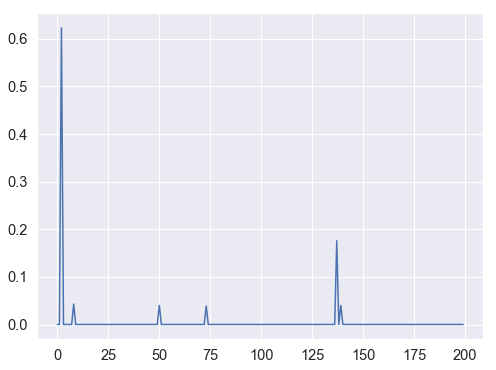

In [1275]:
find_topics(0)

In [1244]:
find_doc_freq_word("entry")

0.017729158807996984

In [1245]:
find_doc_freq_word("table")

0.09788758958883441

Cleaned question n°1:
system dmv  s missing from sql server  master dacpac in ssdt    i have ola hallengren  s excellent maintenance solution scripts incorporated in to a dba tools database project   this is maintained using ssdt  with a target platform of sql server    the project includes references to the built in system databases master   amp   msdb   the project builds successfully      ola has recently   updated   his scripts and they now include references to new sql server  dmv  s   so incorporating the updated scripts into my database project generated unresolved reference errors for the new dmv  s         sql71502   procedure     dbo       databasebackup   has an unresolved reference to object   sys       dm os host info   sql71502   procedure     dbo       databasebackup   has an unresolved reference to object   sys       dm db log stats         although i do n t have sql server  installed anywhere   i tried updating the target platform to sql server  and then deleting and r

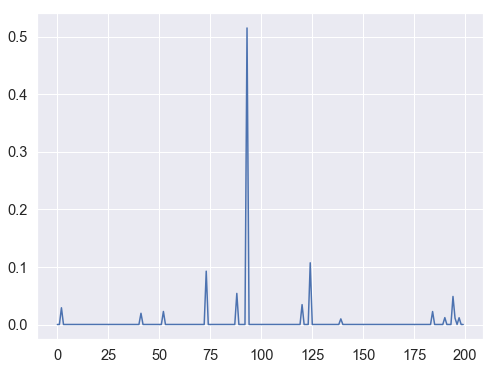

In [1246]:
find_topics(1)

In [1247]:
find_doc_freq_word("sql")

0.05398906073179932

Cleaned question n°123:
updating source of an image in a second html due to output of a javascript eventlistener of the first html page   just to set the scene i  m figuring out web development on my own so do n t have a lot of knowledge and i hope you could help me out      so the concept is on html page  i choose a image and due to the clicking i change it in the second html page      this is the js file linked to the first html page   here i store my source of the chosen image in the variable result        result          document getelementbyid      choice1       addeventlistener      click      function       var elem  document getelementbyid      choice1        result   window getcomputedstyle   elem   null    getpropertyvalue      background image        return result       document getelementbyid      choice2       addeventlistener      click      function       var elem  document getelementbyid      choice2        result   window getcomputedstyle   elem   null    getpropertyva

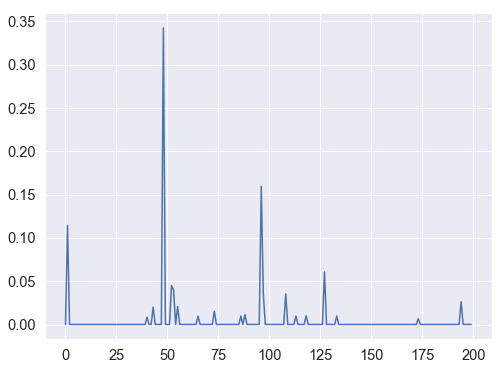

In [1248]:
find_topics(123)

Cleaned question n°18:
display name of properties when looping through errors   i am new to spring so bear with me       i am trying to adjust the display name of properties of an entity in spring boot      i have a form with the following inside to display all errors           lt   ul   gt     lt   li th   each     e         fields detailederrors          th   class         e global     globalerr   fielderr      gt     lt   span th   text         e global                e fieldname        gt   the field name   lt    span   gt     lt   span th   text         e message        gt   the error message   lt    span   gt     lt    li   gt     lt    ul   gt         that results in the following message upon invalid input         error saving new user   please try again lastname must not be empty   firstname size must be between  and    lastname size must be between  and    firstname must not be empty         i have tried adjusting the property to accommodate a display name to no avail        

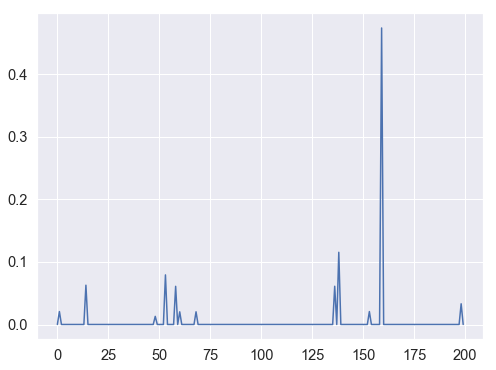

In [1249]:
find_topics(18)

In [1250]:
df_topics_pred.shape

(21208, 200)

In [1251]:
df_quest_cleaned.shape

(21208, 23)

#### Optimization 1

##### Feature 1

max_df=0.11, min_df=10

In [1261]:
# init features
tf_vectorizer = CountVectorizer(max_df=0.11, min_df=10, max_features=1000, 
                                token_pattern='[a-zA-Z0-9]{3,}', stop_words=sw)
tf = tf_vectorizer.fit_transform(token_dict.values())

# Define Search Param
search_params = {'n_components': [100, 150, 200, 250, 300], 
                 'learning_decay': [.5, .7, .9]}# Init the Model
lda_for_gcv = LatentDirichletAllocation(max_iter=5, learning_method='online', 
                                        learning_offset=50.,random_state=0,
                                       n_jobs=-1)# Init Grid Search Class
gcv_lda = GridSearchCV(lda_for_gcv, param_grid=search_params)

# Do the Grid Search
gcv_lda.fit(tf)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [100, 150, 200, 250, 300], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [1262]:
gcv_lda.best_params_

{'learning_decay': 0.7, 'n_components': 100}

In [1264]:
# Best Model
best_lda_model1 = gcv_lda.best_estimator_# Model Parameters
print("Best Model's Params: ", gcv_lda.best_params_)# Log Likelihood Score
print("Best Log Likelihood Score: ", gcv_lda.best_score_)# Perplexity
print("Model Perplexity: ", best_lda_model1.perplexity(tf))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 100}
Best Log Likelihood Score:  -2574933.037294564
Model Perplexity:  409.4999171333012


In [1269]:
df_res = pd.DataFrame(data=gcv_lda.cv_results_)
df_res[df_res["rank_test_score"]<5].T

,0,5,6,7
mean_fit_time,38.6743,38.2101,66.5872,80.1476
std_fit_time,2.66926,0.140548,0.151611,0.344205
mean_score_time,1.2659,1.46367,1.71984,2.06071
std_score_time,0.0431805,0.161575,0.0395789,0.130215
param_learning_decay,0.5,0.7,0.7,0.7
param_n_components,100,100,150,200
params,"{'learning_decay': 0.5, 'n_components': 100}","{'learning_decay': 0.7, 'n_components': 100}","{'learning_decay': 0.7, 'n_components': 150}","{'learning_decay': 0.7, 'n_components': 200}"
split0_test_score,-2.70208e+06,-2.66516e+06,-2.69711e+06,-2.72158e+06
split1_test_score,-2.58378e+06,-2.55419e+06,-2.59105e+06,-2.61919e+06
split2_test_score,-2.53588e+06,-2.50543e+06,-2.54011e+06,-2.57508e+06


Topics : 

In [1521]:
# create & display topic dictionnary 
no_top_words = 10
topic_dict_1 = display_topics(best_lda_model1, tf_vectorizer.get_feature_names(), 
                            no_top_words)

Topic 0:
duration std things hover within setup dist good manually column
Topic 1:
web csv security ssl resource filter collection catalina constraint applicationfilterchain
Topic 2:
input label col font block align style none size placeholder
Topic 3:
apache thread internal source lang invoke util worker main sun
Topic 4:
values spark results bar generator names foo dataset score apply
Topic 5:
content response headers obj upload parse extension invalid application shell
Topic 6:
output result command process param start running age arr cmd
Topic 7:
build react native undefined github sdk meta dist facebook ios
Topic 8:
url page link default icon www browser tab website chrome
Topic 9:
width height layout parent content wrap match http style container
Topic 10:
json store properties enable parse key objects structure stored nested
Topic 11:
curl via doc fine download failed close lists binary ideas
Topic 12:
number options total library question numbers questions answer theme show
Top

Predict Topics for each documents

In [1274]:
topics_pred_1 = best_lda_model1.transform(tf)


In [1290]:
topicNames = []
for idx in range(0, gcv_lda.best_params_["n_components"]):
    topicNames.append("Topic_{}".format(idx))

df_topics_pred_1 = pd.DataFrame(data=topics_pred_1,index=df_quest_cleaned.index,
                               columns=topicNames)
df_model_1 = df_quest_cleaned.join(
    df_topics_pred_1)

In [1291]:
df_model_1.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Topic_88,Topic_89,Topic_90,Topic_91,Topic_92,Topic_93,Topic_94,Topic_95,Topic_96,Topic_97,Topic_98,Topic_99
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.000400,0.097076,0.000400,0.000400,0.000400
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,0.000096,0.000096,0.000096,0.000096,0.000096,0.346594,0.000096,0.000096,0.000096,0.000096,0.019286,0.000096
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,0.000099,0.000099,0.000099,0.000099,0.000099,0.000099,0.032131,0.000099,0.000099,0.000099,0.000099,0.000099
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667,0.001667
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833


In [1302]:
np.max(df_model_1.Tags.str.findall('\<').apply(lambda x: len(x)))

6

In [1303]:
df_model_1.Tags.nunique()

16008

Cleaned question n°0:
how to insert an entry to a table only if it does not exist   my table looks like this on sql server       wordid word                          pen  men  cat       wordid and word is being passed with the stored procedure and   i need to check on my stored procedure if the wordid already exists on the table or not   and only if the wordid does n t exists i need to execute the insert statement    

Tags :  <c#><sql><sql-server>

Index(['Topic_64', 'Topic_66', 'Topic_21'], dtype='object')
[64, 66, 21]
Topic 64 : table database insert price tables mysqli sql real select description
Topic 66 : end loop copy pdf random begin place move procedure declare
Topic 21 : custom mysql integer unique records exists fetch varchar already userid


[64, 66, 21]

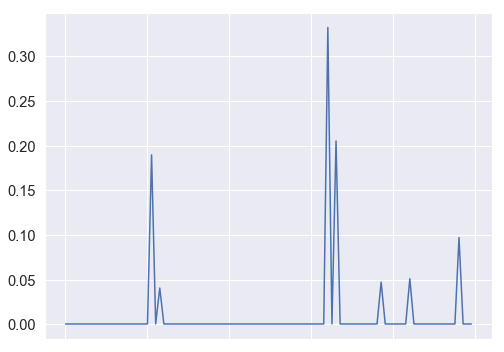

In [1548]:
find_topics(0, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

Cleaned question n°123:
updating source of an image in a second html due to output of a javascript eventlistener of the first html page   just to set the scene i  m figuring out web development on my own so do n t have a lot of knowledge and i hope you could help me out      so the concept is on html page  i choose a image and due to the clicking i change it in the second html page      this is the js file linked to the first html page   here i store my source of the chosen image in the variable result        result          document getelementbyid      choice1       addeventlistener      click      function       var elem  document getelementbyid      choice1        result   window getcomputedstyle   elem   null    getpropertyvalue      background image        return result       document getelementbyid      choice2       addeventlistener      click      function       var elem  document getelementbyid      choice2        result   window getcomputedstyle   elem   null    getpropertyva

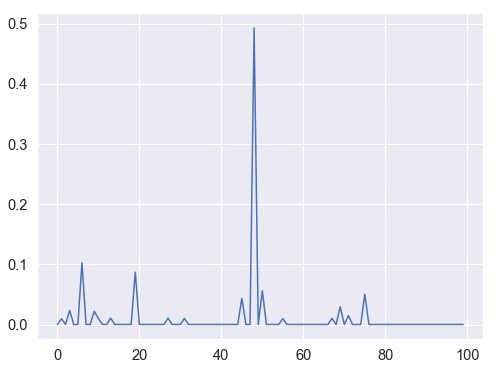

In [1277]:
find_topics(123, df_topics_pred=df_topics_pred_1)

Cleaned question n°132:
fabric wo n t let me link my firebase app   i have an app on my firebase project that i  m trying to link to fabric      when i go to fabric     firebase     set up integration and select the app   it says    already linked          but if i go to firebase console     project settings     integrations     fabric   i do n t see it linked there   i do see some other apps linked   but not the one that i  m trying to link right now      any idea why this could be happening   if i had an old firebase   lt       fabric link   i should at least see it here and be able to remove it   but there  s nothing there   so why does fabric think that my app is already linked   when it  s clearly not    

Tags :  <firebase><google-fabric>

Topic 19 : something see however issue different question change even seems solution
Topic 92 : push double firebase memory point ref notification back structure next
Topic 8 : url page link default icon www browser tab website chrome


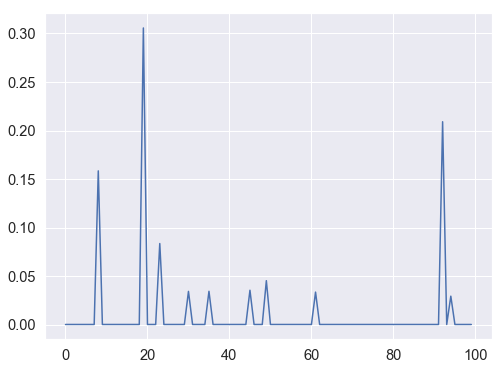

In [1281]:
find_topics(132, df_topics_pred=df_topics_pred_1)

#### Predict tags

Extract all tags : 

In [1430]:
# extract all tags
list_tags_raw=[]
for idx in range(0, df_model_1.shape[0]):
    #print("start...",idx)
    list_tags_raw = list_tags_raw+(re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_model_1.iloc[idx].Tags))
list_tags = list(np.unique(list_tags_raw)) 
print("number of tags:",len(list_tags))
list_tags[:10]

number of tags: 8765


['.app',
 '.htaccess',
 '.lib',
 '.net',
 '.net-1.1',
 '.net-4.0',
 '.net-4.5',
 '.net-4.6',
 '.net-4.6.1',
 '.net-4.6.2']

In [1433]:
re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_model_1.iloc[0].Tags)

['c#', 'sql', 'sql-server']

Create table linking Tags & Topics :

Method :
- For each documents, and for each tags of the document : 
    - we add to its Tag line, its distribution by topics.
- So, Each tags line contains the sum of all topics distribution

In [1467]:
# init dataFrame
df_topics_tags = pd.DataFrame(index=list_tags, columns=topicNames, data=0)

df_model_1_topics = df_model_1.filter(items=topicNames)

t_0 = time.time()
# for each docs, for each of its tags, add its topics distrib  
for idx in range(0, df_model_1_topics.shape[0]):
    list_tags_curr = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_model_1.iloc[idx].Tags)
    for tag_curr in list_tags_curr:
        df_topics_tags.loc[tag_curr] += df_model_1_topics.iloc[idx]

t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))


timing total: 55.48987817764282 s


In [1468]:
df_topics_tags

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_88,Topic_89,Topic_90,Topic_91,Topic_92,Topic_93,Topic_94,Topic_95,Topic_96,Topic_97,Topic_98,Topic_99
.app,0.000270,0.000270,0.000270,0.037065,0.000270,0.000270,0.062312,0.000270,0.085538,0.000270,0.000270,0.000270,...,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270,0.000270
.htaccess,0.013136,0.555620,0.122709,0.325221,0.129565,0.724500,0.244262,0.241866,5.170461,0.047775,0.096178,0.013136,...,0.027841,0.013136,0.219552,0.698814,0.072582,0.181438,3.206592,0.013136,0.045332,0.013136,0.144269,0.046492
.lib,0.000105,0.000105,0.000105,0.000105,0.000105,0.000105,0.000105,0.000105,0.000105,0.021607,0.007687,0.000105,...,0.000105,0.000105,0.000105,0.000105,0.000105,0.024493,0.000105,0.000105,0.000105,0.000105,0.000105,0.000105
.net,0.052624,2.104687,1.100842,2.081942,1.764298,1.589176,3.380935,0.869759,2.039353,0.526407,1.590526,0.052624,...,0.636407,0.052624,0.890876,2.160758,1.442624,9.679244,0.417396,0.052624,2.719356,0.052624,1.234614,0.398883
.net-1.1,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.308462,0.000769,...,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.000769,0.077692,0.000769
.net-4.0,0.000072,0.008627,0.000072,0.000072,0.000072,0.000072,0.055717,0.000072,0.000072,0.000072,0.000072,0.000072,...,0.000072,0.000072,0.007414,0.000072,0.000072,0.073150,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072
.net-4.5,0.000842,0.044545,0.000842,0.000842,0.157724,0.000842,0.000842,0.000842,0.000842,0.000842,0.000842,0.000842,...,0.000842,0.000842,0.000842,0.080412,0.000842,0.000842,0.000842,0.000842,0.000842,0.000842,0.000842,0.000842
.net-4.6,0.000263,0.000263,0.000263,0.000263,0.000263,0.030946,0.000263,0.000263,0.022587,0.000263,0.026579,0.000263,...,0.000263,0.000263,0.030682,0.000263,0.000263,0.265328,0.000263,0.000263,0.000263,0.000263,0.098468,0.000263
.net-4.6.1,0.000244,0.040449,0.011016,0.000244,0.000244,0.022440,0.051042,0.000244,0.000244,0.211540,0.000244,0.000244,...,0.000244,0.000244,0.000244,0.017824,0.008572,0.039855,0.000244,0.000244,0.000244,0.000244,0.017067,0.014594
.net-4.6.2,0.000149,0.016952,0.000149,0.000149,0.000149,0.000149,0.000149,0.026748,0.000149,0.000149,0.000149,0.000149,...,0.000149,0.000149,0.000149,0.000149,0.000149,0.024152,0.000149,0.000149,0.000149,0.000149,0.000149,0.015187


In [1560]:
find_tags_from_topic(8)

['javascript',
 'html',
 'php',
 'python',
 'css',
 'java',
 'jquery',
 'android',
 'angular',
 'c#']

In [1486]:
df_topics_tags.sort_values(by="Topic_8", ascending=False).head(10).index

Index(['javascript', 'html', 'php', 'python', 'css', 'java', 'jquery',
       'android', 'angular', 'c#'],
      dtype='object')

In [1561]:
# exemple : Topic 8 : url page link default icon www browser tab website chrome => .htaccess (5.17..)
topic_dict_1[8]

'url page link default icon www browser tab website chrome'

In [1551]:
topic_dict_1[1]

'web csv security ssl resource filter collection catalina constraint applicationfilterchain'

In [1563]:
find_tags_from_topic(1)

['java',
 'python',
 'javascript',
 'c#',
 'csv',
 'android',
 'php',
 'r',
 'spring',
 'ssl']

In [1552]:
topic_dict_1[2]

'input label col font block align style none size placeholder'

In [1564]:
find_tags_from_topic(2)

['html',
 'javascript',
 'css',
 'jquery',
 'python',
 'php',
 'angular',
 'java',
 'r',
 'c#']

In [1553]:
topic_dict_1[3]

'apache thread internal source lang invoke util worker main sun'

In [1565]:
find_tags_from_topic(3)

['java',
 'android',
 'multithreading',
 'python',
 'apache-spark',
 'c#',
 'spring',
 'javascript',
 'c++',
 'spring-boot']

Find predicted Tags from questions : 
- Find Topics from Questions
- Find Tags from Topics


Cleaned question n°0:
how to insert an entry to a table only if it does not exist   my table looks like this on sql server       wordid word                          pen  men  cat       wordid and word is being passed with the stored procedure and   i need to check on my stored procedure if the wordid already exists on the table or not   and only if the wordid does n t exists i need to execute the insert statement    

Tags :  <c#><sql><sql-server>

Topic 64 : table database insert price tables mysqli sql real select description
Topic 66 : end loop copy pdf random begin place move procedure declare
Topic 21 : custom mysql integer unique records exists fetch varchar already userid


['sql',
 'mysql',
 'php',
 'sql-server',
 'javascript',
 'c#',
 'python',
 'database',
 'java',
 'oracle']

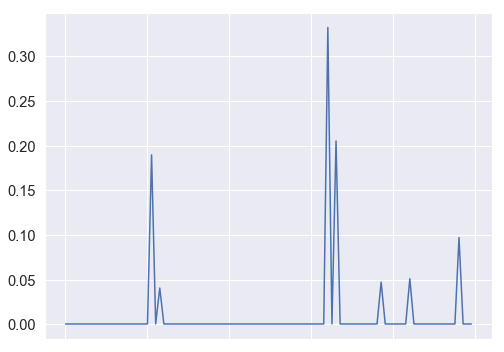

In [1569]:
list_topic_id = find_topics(quest_iloc=0, freq_min=0.1, 
                            df_topics_pred=df_topics_pred_1,
                            topic_dict=topic_dict_1)

find_tags_from_topic(iloc_topic=list_topic_id[0], df_topics_tags=df_topics_tags)

Cleaned question n°1:
system dmv  s missing from sql server  master dacpac in ssdt    i have ola hallengren  s excellent maintenance solution scripts incorporated in to a dba tools database project   this is maintained using ssdt  with a target platform of sql server    the project includes references to the built in system databases master   amp   msdb   the project builds successfully      ola has recently   updated   his scripts and they now include references to new sql server  dmv  s   so incorporating the updated scripts into my database project generated unresolved reference errors for the new dmv  s         sql71502   procedure     dbo       databasebackup   has an unresolved reference to object   sys       dm os host info   sql71502   procedure     dbo       databasebackup   has an unresolved reference to object   sys       dm db log stats         although i do n t have sql server  installed anywhere   i tried updating the target platform to sql server  and then deleting and r

['java',
 'c#',
 'visual-studio',
 'android',
 'python',
 'c++',
 'visual-studio-2017',
 '.net',
 'windows',
 'asp.net']

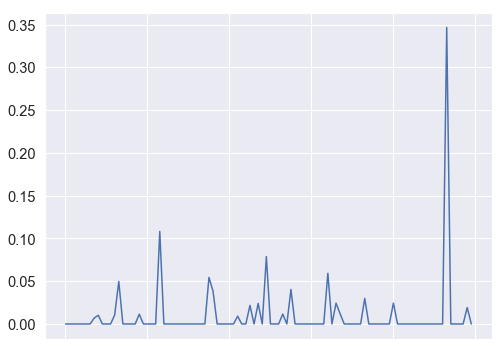

In [1576]:
find_pred_tags_from_quest(quest_iloc=1, freq_min=0.1, 
                          df_topics_pred=df_topics_pred_1,
                          topic_dict=topic_dict_1,
                          df_topics_tags=df_topics_tags)


Cleaned question n°18:
display name of properties when looping through errors   i am new to spring so bear with me       i am trying to adjust the display name of properties of an entity in spring boot      i have a form with the following inside to display all errors           lt   ul   gt     lt   li th   each     e         fields detailederrors          th   class         e global     globalerr   fielderr      gt     lt   span th   text         e global                e fieldname        gt   the field name   lt    span   gt     lt   span th   text         e message        gt   the error message   lt    span   gt     lt    li   gt     lt    ul   gt         that results in the following message upon invalid input         error saving new user   please try again lastname must not be empty   firstname size must be between  and    lastname size must be between  and    firstname must not be empty         i have tried adjusting the property to accommodate a display name to no avail        

['python',
 'javascript',
 'c#',
 'php',
 'java',
 'sql',
 'mysql',
 'html',
 'android',
 'symfony']

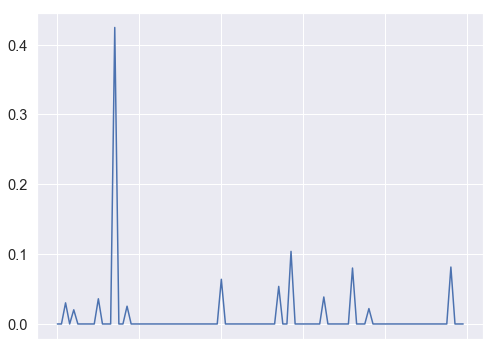

In [1577]:
find_pred_tags_from_quest(quest_iloc=18, freq_min=0.1, 
                          df_topics_pred=df_topics_pred_1,
                          topic_dict=topic_dict_1,
                          df_topics_tags=df_topics_tags)


Cleaned question n°123:
updating source of an image in a second html due to output of a javascript eventlistener of the first html page   just to set the scene i  m figuring out web development on my own so do n t have a lot of knowledge and i hope you could help me out      so the concept is on html page  i choose a image and due to the clicking i change it in the second html page      this is the js file linked to the first html page   here i store my source of the chosen image in the variable result        result          document getelementbyid      choice1       addeventlistener      click      function       var elem  document getelementbyid      choice1        result   window getcomputedstyle   elem   null    getpropertyvalue      background image        return result       document getelementbyid      choice2       addeventlistener      click      function       var elem  document getelementbyid      choice2        result   window getcomputedstyle   elem   null    getpropertyva

['javascript',
 'jquery',
 'html',
 'css',
 'php',
 'python',
 'ajax',
 'c#',
 'java',
 'bootstrap-4']

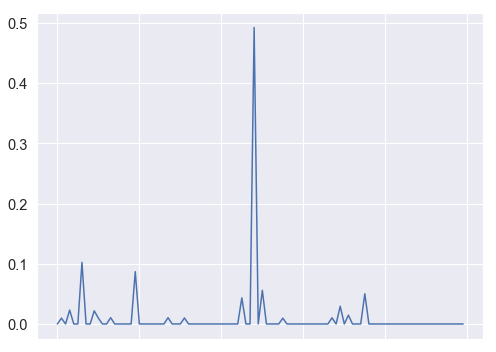

In [1578]:
find_pred_tags_from_quest(quest_iloc=123, freq_min=0.1, 
                          df_topics_pred=df_topics_pred_1,
                          topic_dict=topic_dict_1,
                          df_topics_tags=df_topics_tags)

Predict Tags from question Text :

- Text -> Features
- Features -> TF -> LDA.transfom -> topic ditrib

In [1601]:
df_quest_cleaned.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,Text
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,NaN,2018-04-24 11:03:32,2018-04-24 13:15:50,How to insert an entry to a table only if it d...,<c#><sql><sql-server>,3.0,0,NaN,NaN,NaN,How to insert an entry to a table only if it d...
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,NaN,NaN,2018-05-01 13:24:04,System DMV's missing from SQL Server 2017 mast...,<sql-server><sql-server-data-tools>,1.0,2,NaN,NaN,NaN,System DMV's missing from SQL Server 2017 mast...
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,NaN,2018-04-24 11:28:04,2018-04-24 12:02:43,how to insert data in databse without page rel...,<javascript><php><ajax>,1.0,4,NaN,NaN,NaN,how to insert data in databse without page rel...
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,NaN,NaN,2018-04-24 11:46:52,How to upload image using multipart in Amazon S3,<android><amazon-s3><file-upload><multipart>,1.0,0,NaN,NaN,NaN,How to upload image using multipart in Amazon ...
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,NaN,NaN,2018-04-24 11:05:05,DB2 SQL CROSSTAB,<sql><db2><crosstab>,1.0,0,NaN,NaN,NaN,DB2 SQL CROSSTAB <p>I would like to output a t...


In [1603]:
# example 1st question
text_test = df_quest_cleaned.iloc[0]["Text"]
print(text_test)
# clean the text
text_cleaned = cleaning_text(text_test)

# calculate feature from text
feat_curr =  tf_vectorizer.transform([text_cleaned])

# calculate topic distrib
topic_distrib_pred = best_lda_model1.transform(feat_curr)

# find best topic
find_tags_from_topic(topic_distrib_pred.argmax(), 
                     df_topics_tags=df_topics_tags, 
                     no_max=10)

How to insert an entry to a table only if it does not exist <p>My table looks like this  on sql server</p>

<pre><code>wordId     word      
----------------
1214       pen           
1215       men    
1216       cat  
</code></pre>

<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>



['sql',
 'mysql',
 'php',
 'sql-server',
 'javascript',
 'c#',
 'python',
 'database',
 'java',
 'oracle']

In [1614]:
# example  question
text_test = df_quest_cleaned.iloc[1]["Text"]
print(text_test)
 
find_tags_from_text(text=text_test, tf_vectorizer=tf_vectorizer,
                    lda_model = best_lda_model1,
                    no_max=10)

Display name of properties when looping through errors <p>I am new to Spring so bear with me!</p>

<p>I am trying to adjust the display name of properties of an entity in Spring boot.</p>

<p>I have a form with the following inside to display all errors:</p>

<pre><code>&lt;ul&gt;
    &lt;li th:each="e : ${#fields.detailedErrors()}" th:class="${e.global}? globalerr : fielderr"&gt;
        &lt;span th:text="${e.global}? '*' : ${e.fieldName}"&gt;The field name&lt;/span&gt;
        &lt;span th:text="${e.message}"&gt;The error message&lt;/span&gt;
    &lt;/li&gt;
&lt;/ul&gt;
</code></pre>

<p>That results in the following message upon invalid input:</p>

<blockquote>
  <p>Error Saving New User - Please Try Again
  lastName must not be empty <br>
  firstName size must be between 1 and 30<br>
  lastName size must be between 1 and 30<br>
  firstName must not be empty<br></p>
</blockquote>

<p>I have tried adjusting the property to accommodate a display name to no avail:</p>

<pre><code>@NotEm

['python',
 'javascript',
 'c#',
 'php',
 'java',
 'sql',
 'mysql',
 'html',
 'android',
 'symfony']

In [1619]:
# example  question
text_test = df_quest_cleaned.iloc[18]["Text"]
print(text_test)

# predicted tags
find_tags_from_text(text=text_test, tf_vectorizer=tf_vectorizer,
                    lda_model = best_lda_model1,
                    no_max=10)

Display name of properties when looping through errors <p>I am new to Spring so bear with me!</p>

<p>I am trying to adjust the display name of properties of an entity in Spring boot.</p>

<p>I have a form with the following inside to display all errors:</p>

<pre><code>&lt;ul&gt;
    &lt;li th:each="e : ${#fields.detailedErrors()}" th:class="${e.global}? globalerr : fielderr"&gt;
        &lt;span th:text="${e.global}? '*' : ${e.fieldName}"&gt;The field name&lt;/span&gt;
        &lt;span th:text="${e.message}"&gt;The error message&lt;/span&gt;
    &lt;/li&gt;
&lt;/ul&gt;
</code></pre>

<p>That results in the following message upon invalid input:</p>

<blockquote>
  <p>Error Saving New User - Please Try Again
  lastName must not be empty <br>
  firstName size must be between 1 and 30<br>
  lastName size must be between 1 and 30<br>
  firstName must not be empty<br></p>
</blockquote>

<p>I have tried adjusting the property to accommodate a display name to no avail:</p>

<pre><code>@NotEm

['python',
 'javascript',
 'c#',
 'php',
 'java',
 'sql',
 'mysql',
 'html',
 'android',
 'symfony']

In [1620]:
# example  question
text_test = df_quest_cleaned.iloc[123]["Text"]
print(text_test)

# predicted tags
find_tags_from_text(text=text_test, tf_vectorizer=tf_vectorizer,
                    lda_model = best_lda_model1,
                    no_max=10)


Updating source of an image in a second html due to output of a JavaScript eventlistener of the first html page <p>just to set the scene I'm figuring out web development on my own so don't have a lot of knowledge and I hope you could help me out.</p>

<p>So the concept is on HTML page 1 I choose a image and due to the clicking I change it in the second html page.</p>

<p>This is the js file linked to the first html page. Here I store my source of the chosen image in the variable result.</p>

<pre><code>result="";

document.getElementById("choice1").addEventListener("click", function() { 
var elem =document.getElementById("choice1");
result = window.getComputedStyle(elem, null).getPropertyValue("background-image");
return result
});

document.getElementById("choice2").addEventListener("click", function() { 
var elem =document.getElementById("choice2");
result  = window.getComputedStyle(elem, null).getPropertyValue("background-image");
return result
});

document.getElementById("choice3"

['javascript',
 'jquery',
 'html',
 'css',
 'php',
 'python',
 'ajax',
 'c#',
 'java',
 'bootstrap-4']

#### Optim 2

##### Test Features 2

max_df=0.04, min_df=10

In [1270]:
# init features
tf_vectorizer_2 = CountVectorizer(max_df=0.04, min_df=10, max_features=1000, 
                                token_pattern='[a-zA-Z0-9]{3,}', stop_words=sw)
tf_2 = tf_vectorizer_2.fit_transform(token_dict.values())

# Define Search Param
search_params = {'n_components': [100, 150, 200, 250, 300], 
                 'learning_decay': [.5, .7, .9]}# Init the Model
lda_for_gcv_2 = LatentDirichletAllocation(max_iter=5, learning_method='online', 
                                        learning_offset=50.,random_state=0,
                                       n_jobs=-1)# Init Grid Search Class
gcv_lda_2 = GridSearchCV(lda_for_gcv_2, param_grid=search_params)

# Do the Grid Search
gcv_lda_2.fit(tf_2)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [100, 150, 200, 250, 300], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [1271]:
gcv_lda_2.best_params_

{'learning_decay': 0.7, 'n_components': 100}

In [1272]:
# Best Model
best_lda_model_2 = gcv_lda_2.best_estimator_# Model Parameters
print("Best Model's Params: ", gcv_lda_2.best_params_)# Log Likelihood Score
print("Best Log Likelihood Score: ", gcv_lda_2.best_score_)# Perplexity
print("Model Perplexity: ", best_lda_model_2.perplexity(tf_2))

df_res_2 = pd.DataFrame(data=gcv_lda_2.cv_results_)
df_res_2[df_res_2["rank_test_score"]<5].T

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 100}
Best Log Likelihood Score:  -2574933.037294564
Model Perplexity:  409.4999171333012


,0,5,6,7
mean_fit_time,38.309,38.1469,67.847,85.7211
std_fit_time,1.58339,0.503316,0.871391,4.8859
mean_score_time,1.22754,1.37336,1.71875,2.0812
std_score_time,0.00891823,0.0179528,0.0171224,0.173162
param_learning_decay,0.5,0.7,0.7,0.7
param_n_components,100,100,150,200
params,"{'learning_decay': 0.5, 'n_components': 100}","{'learning_decay': 0.7, 'n_components': 100}","{'learning_decay': 0.7, 'n_components': 150}","{'learning_decay': 0.7, 'n_components': 200}"
split0_test_score,-2.70126e+06,-2.66516e+06,-2.69696e+06,-2.71922e+06
split1_test_score,-2.58378e+06,-2.55419e+06,-2.59105e+06,-2.61666e+06
split2_test_score,-2.53588e+06,-2.50543e+06,-2.54178e+06,-2.57409e+06


### NMF 

NOK

In [687]:
# NMF is able to use tf-idf

no_features = 1000

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, 
                                   max_features=no_features, 
                                   stop_words=sw)

tfidf = tfidf_vectorizer.fit_transform(token_dict.values())

tfidf_feature_names = tfidf_vectorizer.get_feature_names()

no_topics = 200

# Run NMF
nmf = NMF(n_components=no_topics, random_state=0, alpha=.2, l1_ratio=.5, 
          init='nndsvd').fit(tfidf)

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
yes environment exception except excel example ex everything every events
Topic 1:
imgur png img alt src description enter jpg see images
Topic 2:
yes environment exception except excel example ex everything every events
Topic 3:
snippet lang prettyprint override hide babel console css jquery ajax
Topic 4:
yes environment exception except excel example ex everything every events
Topic 5:
yes environment exception except excel example ex everything every events
Topic 6:
self def init func py frame nil models super str
Topic 7:
date datetime format mm time day days convert start current
Topic 8:
view controller findviewbyid views fragment screen override func textview super
Topic 9:
form label submit control post field col group required forms
Topic 10:
list add names arraylist elements items map objects convert values
Topic 11:
react state props native component const render classname export extends
Topic 12:
td tr th table echo row style btn center align
Topic 13:
log console 

## Models Supervised

### Extract n-th first tags from data

In [1633]:
def apply_extract_tag(text_raw, num=0):
    list_tags = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', text_raw)
    try:
        return list_tags[num]
    except:
        return np.nan

df_mdl_sup_1 = df_quest_cleaned.copy()
df_mdl_sup_1["Tag_0"] = df_mdl_sup_1.Tags.apply(apply_extract_tag)
df_mdl_sup_1["Tag_1"] = df_mdl_sup_1.Tags.apply(apply_extract_tag, args=(1,))
df_mdl_sup_1["Tag_2"] = df_mdl_sup_1.Tags.apply(apply_extract_tag, args=(2,))
df_mdl_sup_1["Tag_3"] = df_mdl_sup_1.Tags.apply(apply_extract_tag, args=(3,))
df_mdl_sup_1["Tag_4"] = df_mdl_sup_1.Tags.apply(apply_extract_tag, args=(4,))

df_mdl_sup_1.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,Text,Tag_0,Tag_1,Tag_2,Tag_3,Tag_4
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,<c#><sql><sql-server>,3.0,0,NaN,NaN,NaN,How to insert an entry to a table only if it d...,c#,sql,sql-server,NaN,NaN
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,<sql-server><sql-server-data-tools>,1.0,2,NaN,NaN,NaN,System DMV's missing from SQL Server 2017 mast...,sql-server,sql-server-data-tools,NaN,NaN,NaN
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,<javascript><php><ajax>,1.0,4,NaN,NaN,NaN,how to insert data in databse without page rel...,javascript,php,ajax,NaN,NaN
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,<android><amazon-s3><file-upload><multipart>,1.0,0,NaN,NaN,NaN,How to upload image using multipart in Amazon ...,android,amazon-s3,file-upload,multipart,NaN
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,<sql><db2><crosstab>,1.0,0,NaN,NaN,NaN,DB2 SQL CROSSTAB <p>I would like to output a t...,sql,db2,crosstab,NaN,NaN


### Extracting features from text files

#### Clean text

already done

#### Tokenizing text with scikit-learn

already done

#### TF occurrences

In [1625]:
# init features
tf_vectorizer_1 = CountVectorizer(max_df=0.11, min_df=10, max_features=1000, 
                                token_pattern='[a-zA-Z0-9]{3,}', stop_words=sw)
X_train_counts = tf_vectorizer_1.fit_transform(token_dict.values())
X_train_counts.shape

(21208, 1000)

#### From occurrences to frequencies

In [1626]:
# calculate tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(21208, 1000)

### MultinomialNB classifier

In [1634]:
clf = MultinomialNB().fit(X_train_tfidf, df_mdl_sup_1.Tag_0)

In [1635]:
predicted = clf.predict(X_train_tfidf)

In [1636]:
df_mdl_sup_1["Tag_pred_0"] = predicted

In [1637]:
df_mdl_sup_1.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,Text,Tag_0,Tag_1,Tag_2,Tag_3,Tag_4,Tag_pred_0
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,3.0,0,NaN,NaN,NaN,How to insert an entry to a table only if it d...,c#,sql,sql-server,NaN,NaN,sql
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,1.0,2,NaN,NaN,NaN,System DMV's missing from SQL Server 2017 mast...,sql-server,sql-server-data-tools,NaN,NaN,NaN,c#
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,1.0,4,NaN,NaN,NaN,how to insert data in databse without page rel...,javascript,php,ajax,NaN,NaN,javascript
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,1.0,0,NaN,NaN,NaN,How to upload image using multipart in Amazon ...,android,amazon-s3,file-upload,multipart,NaN,javascript
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,1.0,0,NaN,NaN,NaN,DB2 SQL CROSSTAB <p>I would like to output a t...,sql,db2,crosstab,NaN,NaN,sql


##### Acurracy on train : bad...

In [1638]:
np.mean(df_mdl_sup_1.Tag_0 == df_mdl_sup_1.Tag_pred_0)

0.43158242172764993

### SGDClassifier

In [1641]:
clf_sgc = SGDClassifier(loss='hinge', penalty='l2',
                        alpha=1e-3, random_state=0,
                        max_iter=5, tol=None)

clf_sgc.fit(X_train_tfidf, df_mdl_sup_1.Tag_0)

predicted = clf_sgc.predict(X_train_tfidf)

df_mdl_sup_1["Tag_pred_0"] = predicted
df_mdl_sup_1.head()

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,Text,Tag_0,Tag_1,Tag_2,Tag_3,Tag_4,Tag_pred_0
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,3.0,0,NaN,NaN,NaN,How to insert an entry to a table only if it d...,c#,sql,sql-server,NaN,NaN,c#
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,1.0,2,NaN,NaN,NaN,System DMV's missing from SQL Server 2017 mast...,sql-server,sql-server-data-tools,NaN,NaN,NaN,sql-server
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,1.0,4,NaN,NaN,NaN,how to insert data in databse without page rel...,javascript,php,ajax,NaN,NaN,javascript
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,1.0,0,NaN,NaN,NaN,How to upload image using multipart in Amazon ...,android,amazon-s3,file-upload,multipart,NaN,silverstripe
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,1.0,0,NaN,NaN,NaN,DB2 SQL CROSSTAB <p>I would like to output a t...,sql,db2,crosstab,NaN,NaN,sql


##### Acurracy on train :

In [1672]:
clf_sgc.score(X_train_tfidf, df_mdl_sup_1.Tag_0)

0.6284420973217654

In [1673]:
np.mean(df_mdl_sup_1.Tag_0 == df_mdl_sup_1.Tag_pred_0)

0.6284420973217654

#### Multi-tags

In [1650]:
 df_mdl_sup_1.Tag_0.count() / df_mdl_sup_1.shape[0]

1.0

In [1645]:
 df_mdl_sup_1.Tag_1.count() / df_mdl_sup_1.shape[0]

0.8794322897019993

In [1646]:
 df_mdl_sup_1.Tag_2.count() / df_mdl_sup_1.shape[0]

0.6120803470388533

In [1647]:
 df_mdl_sup_1.Tag_3.count() / df_mdl_sup_1.shape[0]

0.3266220294228593

In [1648]:
 df_mdl_sup_1.Tag_4.count() / df_mdl_sup_1.shape[0]

0.13221425877027537

In [1665]:
df_test = df_mdl_sup_1.filter(items=["Tag_2"])
df_test = df_test.reset_index()
df_test = df_test[df_test["Tag_2"].notna()]
list_id = df_test.index.tolist()
df_test.shape

(12981, 2)

In [1663]:
X_train_tfidf[list_id,:]

<12981x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 377661 stored elements in Compressed Sparse Row format>

In [1664]:
X_train_tfidf

<21208x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 567492 stored elements in Compressed Sparse Row format>

In [1669]:
clf_sgc_2 = SGDClassifier(loss='hinge', penalty='l2',
                        alpha=1e-3, random_state=0,
                        max_iter=5, tol=None)

clf_sgc_2.fit(X_train_tfidf[list_id,:], df_test["Tag_2"])

SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [1671]:
clf_sgc_2.score(X_train_tfidf[list_id,:], df_test["Tag_2"])

0.9162622294122179

In [1679]:
predicted = clf_sgc_2.predict(X_train_tfidf[list_id,:])
df_mdl_sup_1.loc[df_test["index"],"Tag_pred_2"] = predicted
df_mdl_sup_1.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,Text,Tag_0,Tag_1,Tag_2,Tag_3,Tag_4,Tag_pred_0,Tag_pred_2
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,0,NaN,NaN,NaN,How to insert an entry to a table only if it d...,c#,sql,sql-server,NaN,NaN,c#,sql-server
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,2,NaN,NaN,NaN,System DMV's missing from SQL Server 2017 mast...,sql-server,sql-server-data-tools,NaN,NaN,NaN,sql-server,NaN
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,4,NaN,NaN,NaN,how to insert data in databse without page rel...,javascript,php,ajax,NaN,NaN,javascript,http-post
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,0,NaN,NaN,NaN,How to upload image using multipart in Amazon ...,android,amazon-s3,file-upload,multipart,NaN,silverstripe,upload
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,0,NaN,NaN,NaN,DB2 SQL CROSSTAB <p>I would like to output a t...,sql,db2,crosstab,NaN,NaN,sql,winforms


In [1680]:
np.mean(df_mdl_sup_1.Tag_2 == df_mdl_sup_1.Tag_pred_2)

0.5608261033572237

In [1684]:
df_mdl_sup_1.Tag_2.count()

12981

In [1683]:
df_mdl_sup_1.Tag_pred_2.count()

12981